# Estimate Noisy Envelope
---
This notebook estimates Noisy [1,2] envelopes from generated movies. 

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy as sci
from ipywidgets import interact, fixed
import ipywidgets as widgets
import pynoisy.eht_functions as ehtf
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook

Welcome to eht-imaging! v  1.1.1


In [2]:
def plot_envelope(envelope):
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    plt.sca(ax[0])
    envelope.imshow()
    plt.sca(ax[1])
    plt.plot(envelope.data[int(envelope.data.shape[0]/2),:])
    ax[1].set_title('Center slice', fontsize=18)
    plt.tight_layout()
    
def compare_movie_frames(movie1, movie2):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    plt.tight_layout()
    mean_images = [movie1.frames.mean(axis=0), 
                   movie2.frames.mean(axis=0), 
                   (np.abs(movie1.frames - movie2.frames)).mean(axis=0)]
    cbars = []
    for ax, image in zip(axes, mean_images):
        im = ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbars.append(fig.colorbar(im, cax=cax))
                     
    def imshow_frame(i, movie1, movie2, axes, cbars):
        image1 = movie1.frames[i]
        image2 = movie2.frames[i]
        image3 = np.abs(movie1.frames[i] - movie2.frames[i])
        
        for ax, img, title, cbar in zip(axes, [image1, image2, image3], 
                                        ['Movie1', 'Movie2', 'Absolute difference'], cbars):
            im = ax.imshow(img)
            ax.set_title(title)
            cbar.mappable.set_clim([img.min(), img.max()])
            
    interact(
        imshow_frame, i=(0, pynoisy.core.get_num_frames()-1), 
        movie1=fixed(movie1),movie2=fixed(movie2), axes=fixed(axes), cbars=fixed(cbars)
    );
    
def compare_envelopes(env1, env2):
    data1, data2 = env1.data, env2.data
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    im = ax[0].imshow(np.abs(data1 - data2))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax)
    
    ax[0].set_title('Absolute difference', fontsize=16)
    ax[1].plot(np.abs(data1[int(data1.shape[0]/2),:] - data2[int(data2.shape[0]/2),:]))
    ax[1].set_title('Center slice abs-diff', fontsize=16)
    plt.tight_layout()

## Forward Model

### Generate Random Fields

In [13]:
advection = pynoisy.DiskAdvection()
diffusion = pynoisy.RingDiffusion()
solver = pynoisy.PDESolver(advection, diffusion, forcing_strength=0.3)
random_field = solver.run(evolution_length=0.1, verbose=True)
random_field.save('./random_field1.pkl')
solver.reseed()
random_field = solver.run(evolution_length=0.1, verbose=True)
random_field.save('./random_field2.pkl')

Setting solver seed to: 22019
Setting solver seed to: 10864


<IPython.core.display.Javascript object>


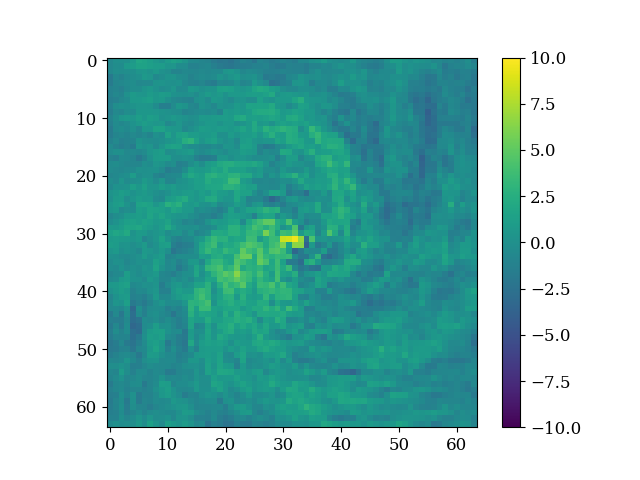

In [11]:
%matplotlib notebook
anim = random_field.get_animation(vmin=-10, vmax=10)

## Inverse Model

### Load Random Fields

<IPython.core.display.Javascript object>


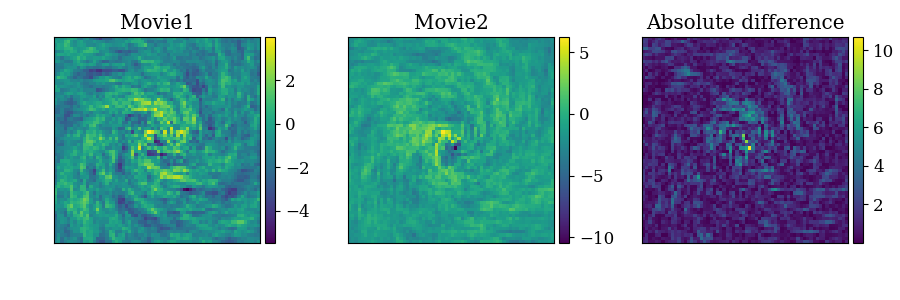

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [14]:
random_field1, random_field2 = pynoisy.Movie(), pynoisy.Movie()
random_field1.load('./random_field1.pkl')
random_field2.load('./random_field2.pkl')
compare_movie_frames(random_field1, random_field2)

### Solve Inverse problem

<IPython.core.display.Javascript object>


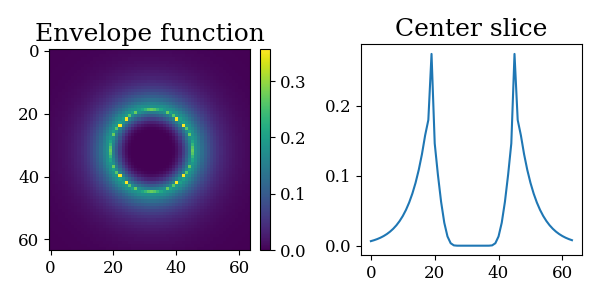

In [15]:
envelope = pynoisy.RingEnvelope(photon_ring_thickness=0.025,photon_ring_decay=200, inner_decay=12, ascent=.65)
plot_envelope(envelope)

<IPython.core.display.Javascript object>


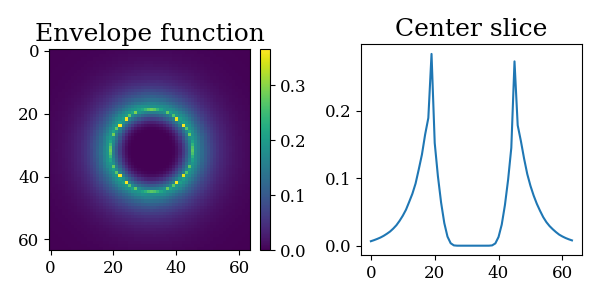

In [17]:
"""
Construct a sparse linear set of equations and solve for the envelope
"""
amplitude = 0.05
movie = envelope.apply(random_field2, amplitude=amplitude)
diags = np.exp(-amplitude * random_field1.frames.reshape(random_field1.num_frames, -1))

b = movie.frames.ravel()
A = sci.sparse.diags(diags, offsets=np.arange(movie.num_frames) * -diags.shape[1], 
                     shape=[diags.shape[1]*diags.shape[0], diags.shape[1]])
sol = sci.sparse.linalg.lsqr(A,b)[0]
envelope_rec = pynoisy.Envelope(data=sol.reshape(random_field1.image_size))
plot_envelope(envelope_rec)

<IPython.core.display.Javascript object>


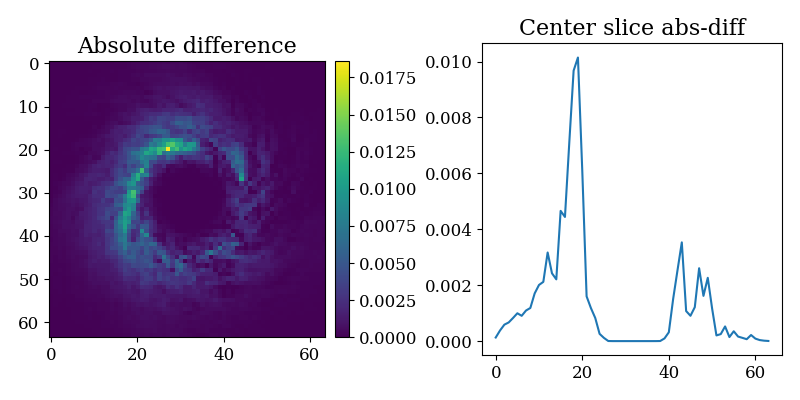

In [18]:
compare_envelopes(envelope, envelope_rec)